In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd
from PIL import Image
import PIL.ImageOps    
import os
import torchvision
import time 
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

Using cpu


Datasets: 
1. AT&T faces (Modified)
2. Omniglot(Single language - Gujarati)

In [3]:
dataset = 1
# Load the training dataset
if dataset == 1:
    folder_dataset_train = datasets.ImageFolder(root=r"data\faces\training")
    folder_dataset_test = datasets.ImageFolder(root=r"data\faces\testing/")
    print(f'Dataset: AT&T faces \n')

elif dataset == 2:
    folder_dataset_train = datasets.ImageFolder(root=r"data\Gujarati\training")
    folder_dataset_test = datasets.ImageFolder(root=r"data\Gujarati\testing/")
    print(f'Dataset: Omniglot(Single language - Gujarati) \n')

d_no_epochs = 25
d_batch_size = 30
def1_margin = 2
def2_margin = 0.5
d_latent = 3

print(f'Summary of training folder: \n {folder_dataset_train} \n ')
print(f'Summary of testing folder: \n {folder_dataset_test} ')
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])


Dataset: AT&T faces 

Summary of training folder: 
 Dataset ImageFolder
    Number of datapoints: 300
    Root location: data\faces\training 
 
Summary of testing folder: 
 Dataset ImageFolder
    Number of datapoints: 100
    Root location: data\faces\testing/ 


In [4]:
# Creating some helper functions
def imshow(img, text=None):
    plt.figure(figsize=(8,4))
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Siamese Neural Network: CNN+FC

In [5]:
torch.manual_seed(101)
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self,latent):
        super(SiameseNetwork, self).__init__()
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )
        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,latent)
        )
        
    def forward_once(self, x):
        # This function will be called for each images
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, anchor, positive, negative, edgecase):
        # In this function we pass all images and obtain latent space embeddings
        output_anchor = self.forward_once(anchor)
        output_positive = self.forward_once(positive)
        output_negative = self.forward_once(negative)
        output_edgecase = self.forward_once(edgecase)

        return output_anchor, output_positive, output_negative, output_edgecase

Dataset Loader

In [6]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None,test =False):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.test = test
        self.files = iter(self.imageFolderDataset.imgs)
        self.current_file = next(self.files)
        self.test_data = True
        random.seed(42)
        
    def __getitem__(self,index):
        if not self.test:
            anchor_tuple = random.choice(self.imageFolderDataset.imgs)
            while True:
                #Look untill the same class image is found
                positive_tuple = random.choice(self.imageFolderDataset.imgs) 
                if (anchor_tuple[1] == positive_tuple[1]) and (anchor_tuple[0] != positive_tuple[0]):
                    break

            while True:
                #Look untill a different class image is found
                negative_tuple = random.choice(self.imageFolderDataset.imgs) 
                if anchor_tuple[1] != negative_tuple[1]:
                    break

            while True:
                # Look untill a completely different class image is found
                edgecase_tuple = random.choice(self.imageFolderDataset.imgs)
                if (edgecase_tuple[1] != negative_tuple[1]) and (edgecase_tuple[1] != positive_tuple[1]) and (edgecase_tuple[1] != anchor_tuple[1]):
                    break

            anchor = Image.open(anchor_tuple[0])
            positive = Image.open(positive_tuple[0])
            negative = Image.open(negative_tuple[0])
            edgecase = Image.open(edgecase_tuple[0])
            label = [anchor_tuple[0].split('\\')[-2]]
        
        else:
            if self.test_data:
                self.anchor_tuple = self.current_file
                self.current_file = next(self.files)
                self.positive_tuple1 = self.current_file
                self.current_file = next(self.files)
                self.positive_tuple2 = self.current_file
                self.current_file = next(self.files)
                self.test_data = False
                 
            if self.anchor_tuple[1] == self.current_file[1]:
                self.positive_tuple3 = self.current_file
                self.current_file = next(self.files)
            else:
                self.anchor_tuple = self.current_file
                self.current_file = next(self.files)
                self.positive_tuple1 = self.current_file
                self.current_file = next(self.files)
                self.positive_tuple2 = self.current_file
                self.current_file = next(self.files)
                if self.anchor_tuple[1] == self.current_file[1]:
                    self.positive_tuple3 = self.current_file
            
            anchor = Image.open(self.anchor_tuple[0])
            positive = Image.open(self.positive_tuple1[0])
            negative = Image.open(self.positive_tuple2[0])
            edgecase = Image.open(self.positive_tuple3[0])
            label = [self.anchor_tuple[0].split('\\')[-2]]  

        anchor = anchor.convert("L")
        positive = positive.convert("L")
        negative = negative.convert("L")
        edgecase =edgecase.convert("L")

        if self.transform is not None:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
            edgecase = self.transform(edgecase)
        
        
        return anchor, positive, negative, edgecase, label
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
    
    def get_current_value(self):
        if self.index >= len(self.iterable):
            raise StopIteration
        return self.iterable[self.index]

Sample Batch Visualization

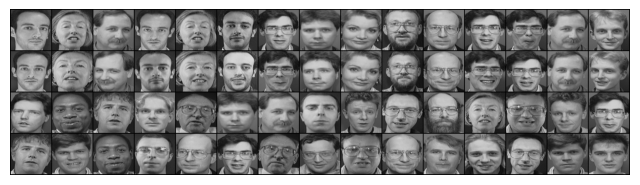

Anchor labels: [('s16', 's32', 's25', 's16', 's32', 's16', 's20', 's23', 's35', 's14', 's13', 's20', 's20', 's25', 's40')]


In [7]:
# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_train, transform=transformation,test = False)
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=15)

# Extract one batch
example_batch = next(iter(vis_dataloader))
# Example batch is a list containing 3x11 images
concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[2], example_batch[3]),0)
imshow(torchvision.utils.make_grid(concatenated,nrow=15))
print(f"Anchor labels: {example_batch[4]}")


In [8]:
# Define the Quadruplet Loss Function
class QuadrupletLoss(torch.nn.Module):
    def __init__(self, margin1 =def1_margin, margin2 = def2_margin):
        super(QuadrupletLoss, self).__init__()
        self.margin1 = margin1
        self.margin2 = margin2

    
    def forward(self, anchor, positive, negative, edgecase):
        #Calculate the eucidian distance and calculate the Triplet Loss
        distance_positive = F.pairwise_distance(anchor, positive, keepdim=True)
        distance_negative = F.pairwise_distance(anchor, negative, keepdim=True)
        distance_edgecase = F.pairwise_distance(negative, edgecase, keepdim= True)

        loss_quadruplet = torch.mean(F.relu((distance_positive - distance_negative + self.margin1)+(F.relu(distance_positive - distance_edgecase+ self.margin2))))

        return loss_quadruplet

In [9]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_train, transform=transformation,test = False)
train_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=d_batch_size)
net = SiameseNetwork(d_latent).to(device)
criterion = QuadrupletLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

Training

Epoch [1/25], Batch [10/10], Loss: 1.9858444690704347
Time: 7.59 seconds
Epoch [2/25], Batch [10/10], Loss: 1.1733744323253632
Time: 8.07 seconds
Epoch [3/25], Batch [10/10], Loss: 0.9838692665100097
Time: 7.99 seconds
Epoch [4/25], Batch [10/10], Loss: 1.1027783811092378
Time: 8.00 seconds
Epoch [5/25], Batch [10/10], Loss: 0.9237100660800934
Time: 7.92 seconds
Epoch [6/25], Batch [10/10], Loss: 0.7097723752260208
Time: 7.49 seconds
Epoch [7/25], Batch [10/10], Loss: 0.7416379630565644
Time: 7.36 seconds
Epoch [8/25], Batch [10/10], Loss: 0.6507044553756713
Time: 7.54 seconds
Epoch [9/25], Batch [10/10], Loss: 0.7259763747453689
Time: 7.50 seconds
Epoch [10/25], Batch [10/10], Loss: 0.71103495657444
Time: 7.66 seconds
Epoch [11/25], Batch [10/10], Loss: 0.7031535148620606
Time: 7.60 seconds
Epoch [12/25], Batch [10/10], Loss: 0.597768247127533
Time: 7.49 seconds
Epoch [13/25], Batch [10/10], Loss: 0.545807808637619
Time: 7.71 seconds
Epoch [14/25], Batch [10/10], Loss: 0.4801292568445

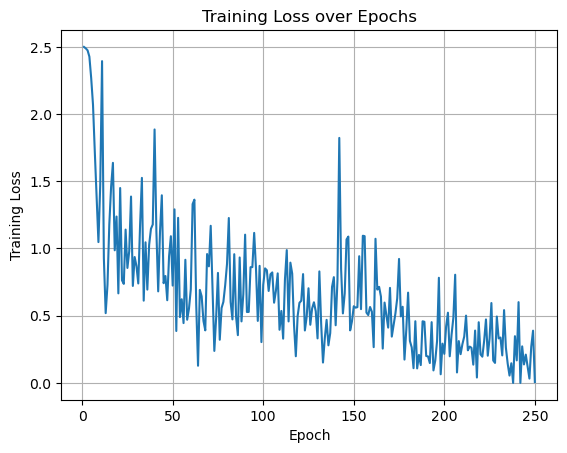

Training finished.


In [10]:

counter = []
loss_history = [] 
iteration_no = 0
# Training loop
for epoch in range(d_no_epochs):
    #set the network in training mode
    net.train()
    
    # Initialize the running loss
    running_loss = 0.0

    # Initialize the start time for the epoch
    epoch_start_time = time.time()
    
    # Iterate over the batches in the dataloader
    for i, (anchor, positive, negative, edgecase,_)  in enumerate(train_dataloader):
        # print(anchor,positive, negative, edgecase)
        """ """ # Transfer images and labels to the device
        anchor, positive, negative, edgecase = anchor.to(device), positive.to(device), negative.to(device), edgecase.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output_anchor, output_positive, output_negative, output_edgecase = net(anchor, positive, negative,edgecase)
        
        # Calculate the triplet loss
        loss_quadruplet = criterion(output_anchor, output_positive, output_negative, output_edgecase)
        
        # Backward pass and optimization
        loss_quadruplet.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss_quadruplet.item()

        # Print the loss every 
        if (i + 1) % len(train_dataloader) == 0:
            print(f"Epoch [{epoch+1}/{d_no_epochs}], Batch [{i+1}/{len(train_dataloader)}], Loss: {running_loss / len(train_dataloader)}")
            running_loss = 0.0
        
        iteration_no += 1
        
        loss_history.append(loss_quadruplet.item())
        counter.append(iteration_no)

    # End of epoch
    # Calculate the epoch running time
    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time

    # Print epoch summary
    print(f"Time: {epoch_time:.2f} seconds")
    
# Training complete
plt.plot(counter, loss_history)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()
print("Training finished.")

Trainig result visualization

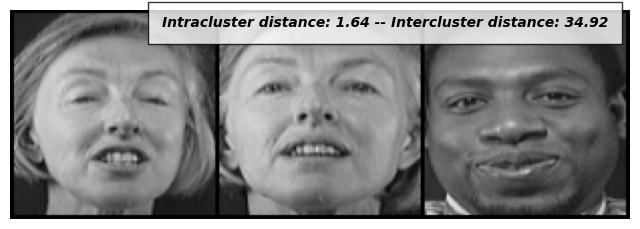

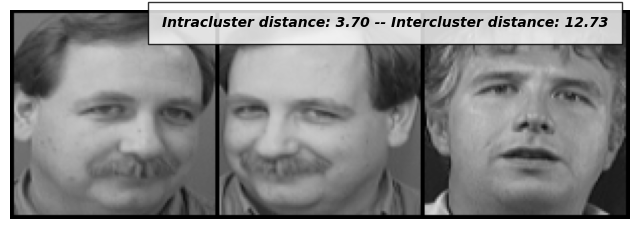

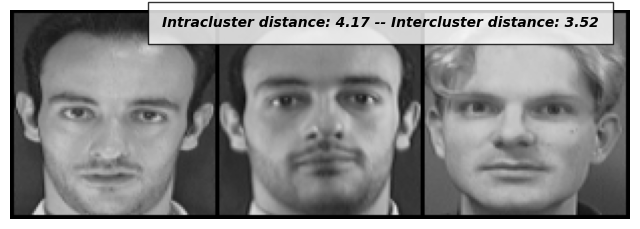

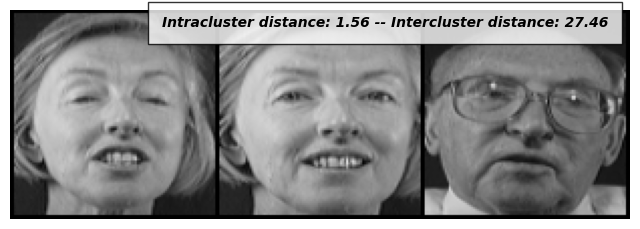

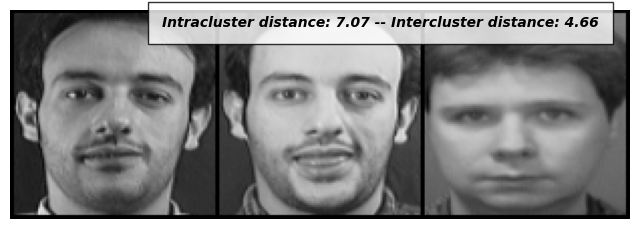

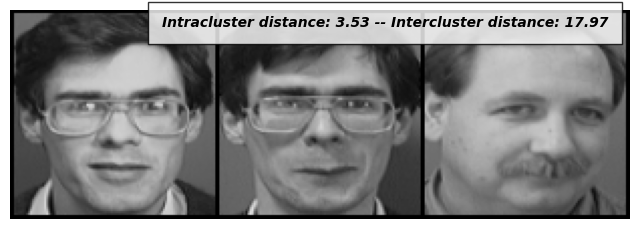

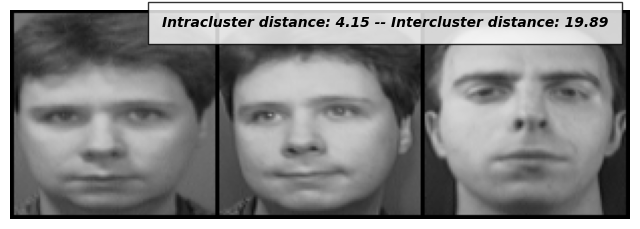

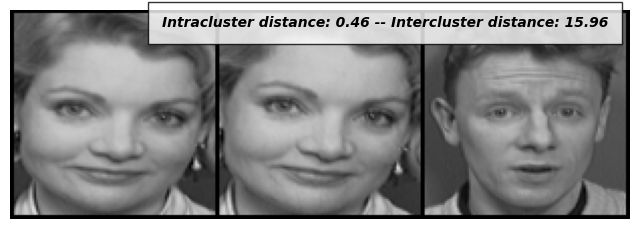

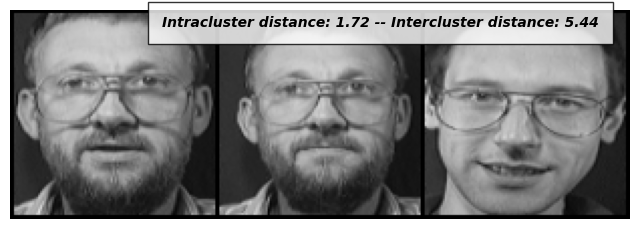

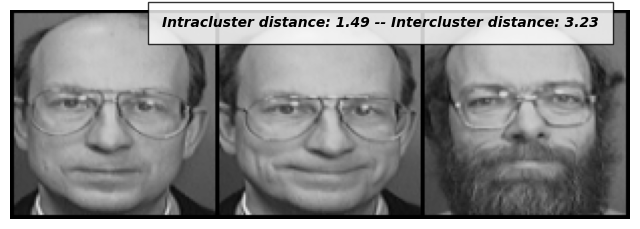

In [11]:
# Load it into the SiameseNetworkDataset

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_train,
                                        transform=transformation)
train_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(train_dataloader)
anchor, positive, negative, _,_ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    anchor, positive, negative, _,_ = next(dataiter)

    # Concatenate the three images together
    concatenated = torch.cat((anchor, positive, negative), 0)
    
    output_anchor, output_positive, output_negative, output_edgecase = net(anchor.to(device), positive.to(device), negative.to(device),edgecase.to(device))
    euclidean_distance_positive = F.pairwise_distance(output_anchor, output_positive)
    euclidean_distance_negative = F.pairwise_distance(output_anchor, output_negative)
    imshow(torchvision.utils.make_grid(concatenated), f'Intracluster distance: {euclidean_distance_positive.item():.2f} -- Intercluster distance: {euclidean_distance_negative.item():.2f}')


Visualizing the latent space

In [12]:
if d_latent == 2:
    plot_batch = 10
    train_results = []
    labels = []
    net.eval()
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_train,
                                            transform=transformation)
    # Create a simple dataloader just for simple visualization
    vis_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            batch_size=d_batch_size)


    with torch.no_grad():
        for i,batch in enumerate(vis_dataloader):
            if i >= plot_batch:
                break
            anchor, _, _, _,label = batch
            anchor = anchor.to(device)
            output_anchor = net.forward_once(anchor)
            train_results.append(output_anchor.cpu().numpy())
            labels.append(label[0])

    train_results = np.concatenate(train_results)
    labels = np.concatenate(labels)
    labels=np.array(labels)
    combined_data = list(zip(train_results,labels))

    cmap = plt.cm.get_cmap('brg', len(np.unique([point[1] for point in combined_data])))
    fig = plt.figure()
    ax = fig.add_subplot()
    for label in enumerate(np.unique([point[1] for point in combined_data])):
        points = [data[0] for data in combined_data if data[1]==label[1]]
        ax.scatter([point[0] for point in points], [point[1] for point in points], c=cmap(label[0]), label=label[1],s =  0.5)
        points = np.concatenate(points)
        points=points.reshape(-1,2)
        group_means = np.mean(points,axis=0)
        group_std = np.std(points, axis=0)
        group_range = np.ptp(points, axis=0)
        # Plot the mean as a center point
        ax.plot(group_means[0], group_means[1],marker ="*", color=cmap(label[0]))

    ax.grid(True)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    # plt.zlabel('Altitude')
    plt.title('Embeddings trainig set in Latent Space')
    plt.legend(loc=(1.1, 0))

Defining the threshold by data distribution of positive and negative distance for classification:

300


,Pos Dist,Neg Dist
count,299.000000,299.000000
mean,2.446661,13.946864
std,1.754314,8.483732
min,0.066310,0.865528
25%,1.070093,7.719871
50%,1.963091,12.353525
75%,3.280917,19.398278
max,9.823782,39.133965


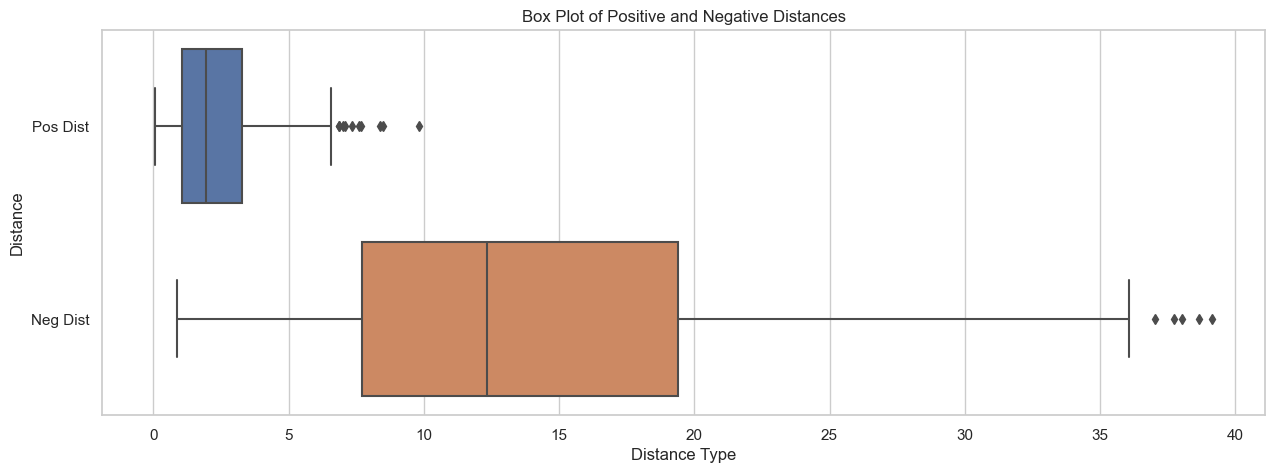

In [13]:
# Load it into the SiameseNetworkDataset

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_train,
                                        transform=transformation)
train_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(train_dataloader)
anchor, positive, negative, _,_ = next(dataiter)
pos_dist = []
neg_dist = []
print(len(train_dataloader))
for i in range(len(train_dataloader)-1):
    # Iterate over 10 images and test them with the first image (x0)
    anchor, positive, negative, _,_ = next(dataiter)

    output_anchor, output_positive, output_negative = net.forward_once(anchor.to(device)), net.forward_once(positive.to(device)), net.forward_once(negative.to(device))
    euclidean_distance_positive = F.pairwise_distance(output_anchor, output_positive)
    euclidean_distance_negative = F.pairwise_distance(output_anchor, output_negative)
    # print(euclidean_distance_positive)
    pos_dist.append(euclidean_distance_positive.detach().cpu().numpy())
    neg_dist.append(euclidean_distance_negative.detach().cpu().numpy())

pos_dist = [x[0] for x in pos_dist]
neg_dist = [x[0] for x in neg_dist]

# Combine positive and negative distances for the box plot
distances = [pos_dist, neg_dist]

distance_data = {'Pos Dist':pos_dist,'Neg Dist':neg_dist}
df1 = pd.DataFrame(distance_data)
df1.head()

# Set the style of the plot
sns.set(style="whitegrid")

# Create the box plot using seaborn
plt.figure(figsize=(15,5))
sns.boxplot(data=df1,orient='h')

# Set the labels for x-axis and y-axis
plt.xlabel('Distance Type')
plt.ylabel('Distance')

# Set the title of the plot
plt.title('Box Plot of Positive and Negative Distances')

df1.describe()

Finding the accuracy based on the threshold decided:

In [17]:
# Load it into the SiameseNetworkDataset

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test, transform=transformation,test = True)
test_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Grab one image that we are going to test
net.eval()
neg_dist = []
dataiter = iter(test_dataloader)
with torch.no_grad():
    while True:
        try:
            anchor, positive, negative, edgecase, _ = next(dataiter)

            output_anchor = net.forward_once(anchor.to(device))
            output_edgecase = net.forward_once(edgecase.to(device))
            euclidean_distance_negative = F.pairwise_distance(output_anchor, output_edgecase)
            neg_dist.append(euclidean_distance_negative.detach().cpu().numpy())
        except StopIteration:
            break


neg_dist = [x[0] for x in neg_dist]

# Combine positive and negative distances for the box plot
distances = [neg_dist]

distance_data = {'Neg Dist':neg_dist}
df = pd.DataFrame(distance_data)
df.head()
print(f"Quantile(87.5%): {df1['Pos Dist'].quantile(0.875)}")
print(f"Accuracy : {100*(len(df[df['Neg Dist'] < df1['Pos Dist'].quantile(0.875)])/len(df)):.2f}")

df.describe()

Quantile(87.5%): 4.569253325462341
Accuracy : 84.62


,Neg Dist
count,78.000000
mean,2.672158
std,1.783984
min,0.324210
25%,1.416658
50%,2.255511
75%,3.846878
max,6.714526


Different Class Distance of test data

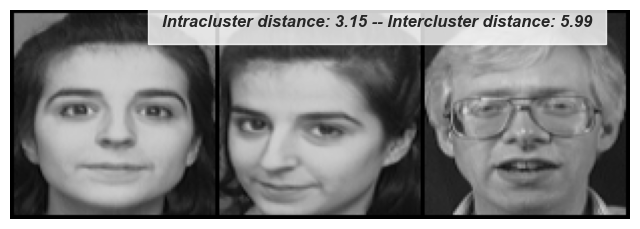

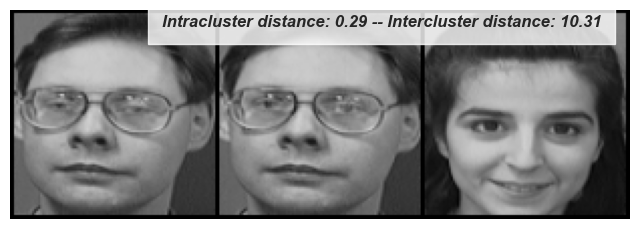

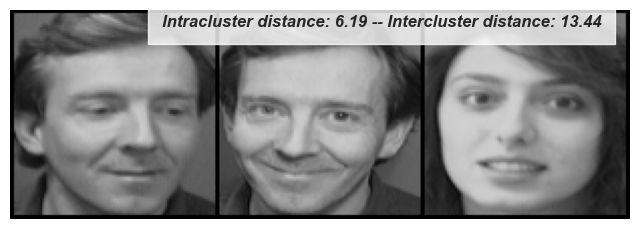

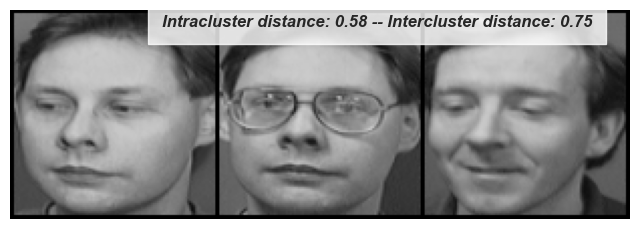

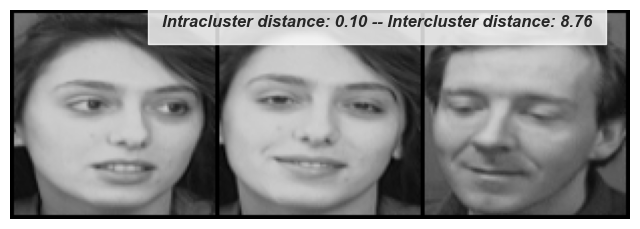

In [21]:
# Load it into the SiameseNetworkDataset

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
train_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(train_dataloader)
anchor, positive, negative, _,_ = next(dataiter)

for i in range(5):
    # Iterate over 10 images and test them with the first image (x0)
    anchor, positive, negative, _,_ = next(dataiter)

    # Concatenate the three images together
    concatenated = torch.cat((anchor, positive, negative), 0)
    
    output_anchor, output_positive, output_negative, output_edgecase = net(anchor.to(device), positive.to(device), negative.to(device),edgecase.to(device))
    euclidean_distance_positive = F.pairwise_distance(output_anchor, output_positive)
    euclidean_distance_negative = F.pairwise_distance(output_anchor, output_negative)
    imshow(torchvision.utils.make_grid(concatenated), f'Intracluster distance: {euclidean_distance_positive.item():.2f} -- Intercluster distance: {euclidean_distance_negative.item():.2f}')

Similar Class Distance of test data

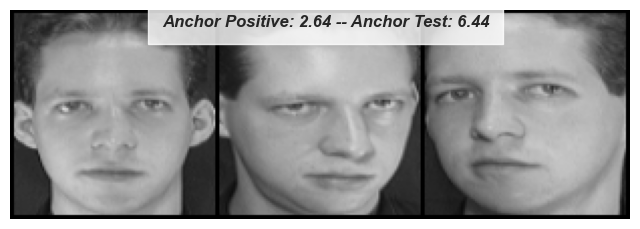

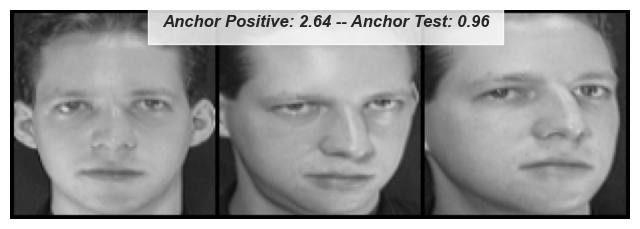

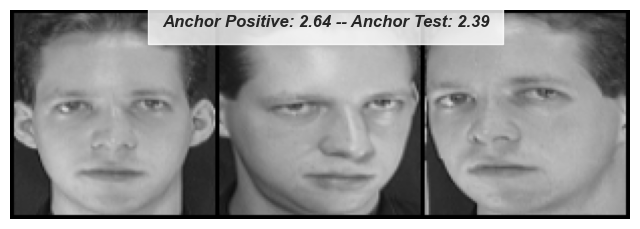

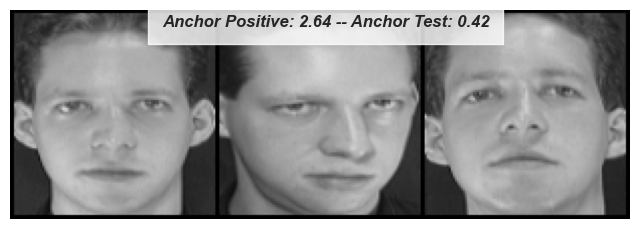

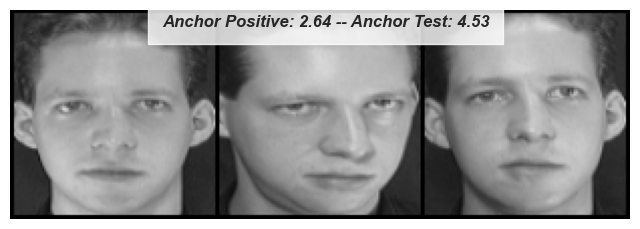

In [22]:
# Load it into the SiameseNetworkDataset

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation, test=True)
train_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(train_dataloader)
anchor, positive, _,edgecase,_ = next(dataiter)

for i in range(5):
    # Iterate over 10 images and test them with the first image (x0)
    anchor, positive, _,edgecase,_ = next(dataiter)

    # Concatenate the three images together
    concatenated = torch.cat((anchor, positive, edgecase), 0)
    
    output_anchor, output_positive, output_negative  = net.forward_once(anchor.to(device)), net.forward_once(positive.to(device)), net.forward_once(edgecase.to(device))
    euclidean_distance_positive = F.pairwise_distance(output_anchor, output_positive)
    euclidean_distance_negative = F.pairwise_distance(output_anchor, output_negative)
    imshow(torchvision.utils.make_grid(concatenated), f'Anchor Positive: {euclidean_distance_positive.item():.2f} -- Anchor Test: {euclidean_distance_negative.item():.2f}')